In [ ]:
!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/detectron2.git

In [ ]:
!git clone https://github.com/facebookresearch/meshrcnn.git
%cd meshrcnn
!pip install -e .


Loading image...
Setting up Mask R-CNN...
Running inference...
Visualizing results...


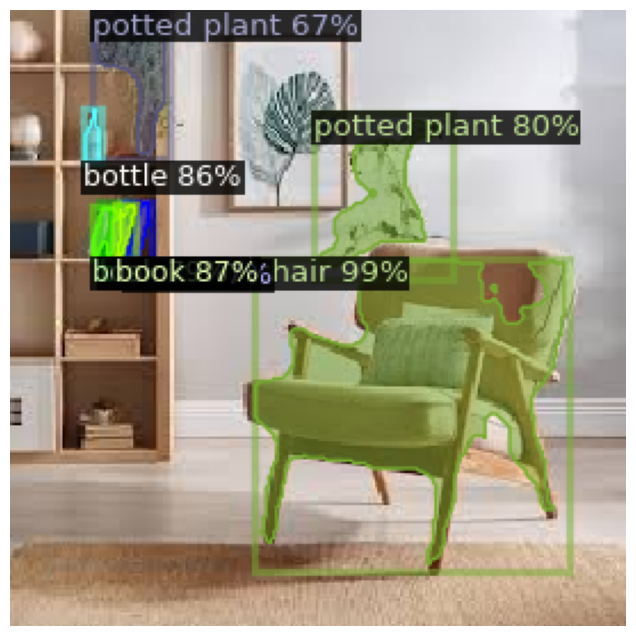


Detected 8 objects:
Object 1: chair with confidence 0.99
Object 2: book with confidence 0.87
Object 3: bottle with confidence 0.86
Object 4: potted plant with confidence 0.80
Object 5: book with confidence 0.79
Object 6: book with confidence 0.77
Object 7: book with confidence 0.68
Object 8: potted plant with confidence 0.67

Results saved to output

Processing completed successfully!


<Figure size 640x480 with 0 Axes>

In [24]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

def load_image(image_path):
    """Load and validate image"""
    image_path = Path(image_path)
    if not image_path.exists():
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    image = cv2.imread(str(image_path))
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}")
    
    # Ensure image is in RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def setup_maskrcnn():
    """Configure Mask R-CNN model for CPU usage"""
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    
    # Force CPU configuration
    cfg.MODEL.DEVICE = "cpu"
    
    # Other configurations
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    
    return DefaultPredictor(cfg), cfg

def process_image(image_path):
    """Process image through Mask R-CNN using CPU"""
    try:
        # Load image
        print("Loading image...")
        image = load_image(image_path)
        
        # Setup model
        print("Setting up Mask R-CNN...")
        predictor, cfg = setup_maskrcnn()
        
        # Run prediction
        print("Running inference...")
        with torch.no_grad():
            outputs = predictor(image)
        
        # Visualize results
        print("Visualizing results...")
        v = Visualizer(image, 
                      MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
                      scale=1.2)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        # Display results
        plt.figure(figsize=(12, 8))
        plt.imshow(out.get_image())
        plt.axis("off")
        plt.show()
        
        # Extract and return predictions
        instances = outputs["instances"]
        results = {
            "masks": instances.pred_masks.numpy(),
            "boxes": instances.pred_boxes.tensor.numpy(),
            "classes": instances.pred_classes.numpy(),
            "scores": instances.scores.numpy()
        }
        
        # Print detection summary
        n_objects = len(results['classes'])
        print(f"\nDetected {n_objects} objects:")
        
        # Get class names from metadata
        metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
        class_names = metadata.thing_classes
        
        for i, (cls, score) in enumerate(zip(results['classes'], results['scores'])):
            class_name = class_names[cls] if cls < len(class_names) else f"Class {cls}"
            print(f"Object {i+1}: {class_name} with confidence {score:.2f}")
        
        return results
        
    except Exception as e:
        print(f"Error during processing: {str(e)}")
        raise

def save_visualization(image_path, results_path="output"):
    """Save visualization results"""
    try:
        results = process_image(image_path)
        
        # Create output directory if it doesn't exist
        output_dir = Path(results_path)
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Save the visualization
        plt.savefig(output_dir / "detection_results.png")
        print(f"\nResults saved to {output_dir}")
        
        return results
    
    except Exception as e:
        print(f"\nFailed to process image: {str(e)}")
        print("\nTroubleshooting steps:")
        print("1. Verify the image path is correct")
        print("2. Ensure you have sufficient memory")
        print("3. Check that all dependencies are properly installed")
        return None

def main():
    # Update this path to your image location
    image_path = '/hacktwofuture/images.jpeg'
    
    try:
        # Process and save results
        results = save_visualization(image_path)
        
        if results is not None:
            print("\nProcessing completed successfully!")
            
    except KeyboardInterrupt:
        print("\nProcessing interrupted by user")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {str(e)}")

if __name__ == "__main__":
    main()